**Standard operations to make the import possible**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! cp /content/drive/MyDrive/lfw_dataset.py /content/

In [ ]:
! ls -a

.  ..  .config	drive  lfw_dataset.py  sample_data


Libraries and data import

In [ ]:
import os
import numpy as np
import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import time
%matplotlib inline

In [ ]:
# The following code fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind
from lfw_dataset import fetch_lfw_dataset

data, attrs = fetch_lfw_dataset()

images not found, donwloading...
extracting...
done
attributes not found, downloading...
done


In [ ]:
print(attrs.shape)
print(data.shape)
attrs.head()

(13143, 73)
(13143, 45, 45, 3)


,Male,Asian,White,Black,Baby,Child,Youth,Middle Aged,Senior,Black Hair,...,Pale Skin,5 o' Clock Shadow,Strong Nose-Mouth Lines,Wearing Lipstick,Flushed Face,High Cheekbones,Brown Eyes,Wearing Earrings,Wearing Necktie,Wearing Necklace
0,1.568346,-1.889043,1.737203,-0.929729,-1.471799,-0.19558,-0.835609,-0.351468,-1.012533,-0.719593,...,0.361738,1.166118,-1.164916,-1.13999,-2.371746,-1.299932,-0.414682,-1.144902,0.694007,-0.826609
1,0.169851,-0.982408,0.422709,-1.282184,-1.36006,-0.867002,-0.452293,-0.197521,-0.956073,-0.802107,...,-0.832036,-0.39768,0.87416,-0.945431,-0.268649,-0.006244,-0.030406,-0.480128,0.66676,-0.496559
2,0.997749,-1.364195,-0.157377,-0.756447,-1.891825,-0.871526,-0.862893,0.031445,-1.341523,-0.090037,...,1.549743,1.884745,-0.999765,-1.359858,-1.912108,-1.095634,0.915126,-0.572332,0.144262,-0.841231
3,1.122719,-1.997799,1.916144,-2.514214,-2.580071,-1.404239,0.057551,0.000196,-1.273512,-1.431462,...,0.567822,-0.176089,1.108125,-1.600944,-3.264613,0.813418,0.308631,-0.848693,0.475941,-0.447025
4,1.078214,-2.008098,1.676211,-2.278056,-2.651845,-1.348408,0.649089,0.017656,-1.889111,-1.857213,...,-1.461474,-0.955283,0.119113,-1.128176,-3.161048,0.08268,-0.439614,-0.359859,-0.760774,-0.410152


Data preprocessing

In [ ]:
X_train = data[:10000].reshape((10000, 45, 45, 3)).astype('float32')
print(X_train.shape)
X_val = data[10000:].astype('float32')
print(X_val.shape)

image_h = data.shape[1]
image_w = data.shape[2]

X_train = np.float32(X_train)
X_train = X_train/255
X_val = np.float32(X_val)
X_val = X_val/255

(10000, 45, 45, 3)
(3143, 45, 45, 3)


Some helper functions by Nairi :)

In [ ]:
def plot_gallery(images, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w, 3)), cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
        plt.xticks(())
        plt.yticks(())

In [ ]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def __init__(self, model, rate):
        super(DisplayCallback, self).__init__()
        self.model = model
        self.rate = rate

    def on_epoch_end(self, epoch, logs=None):
        model = self.model
        if epoch % self.rate == 0:
            idx = np.random.choice(X_train.shape[0])
            plt.subplot(221)
            plt.imshow(X_train[idx].reshape(
                (image_h, image_w, 3)
            ))
            plt.subplot(222)
            plt.imshow(tf.reshape(
                model(X_train[tf.newaxis, idx]), (image_h, image_w, 3)
            ))
            idx = np.random.choice(X_val.shape[0])
            plt.subplot(223)
            plt.imshow(X_val[idx].reshape(
                (image_h, image_w, 3)
            ))
            plt.subplot(224)
            plt.imshow(tf.reshape(
                model(X_val[tf.newaxis, idx]), (image_h, image_w, 3)
            ))
            plt.show()

Sampling class decalaration: Required for latent space

In [ ]:
class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs

        batch_size = tf.shape(mean)[0]
        latent_dim = tf.shape(mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch_size, latent_dim))
        z = mean + tf.exp(0.5 * log_var) * epsilon

        return z

As the project is doing all the calculations for images, it was a MUST for me to include some convolutions in encoder and transposed convolutions in decoder :)

The encoder takes the image as it is, passes through some blocks, flattens and then uses the output for the reparametrization. The output of encoder is a list including the mean, log(sigma^2) and z latent vector

We train the log(sigma^2) to make sure that the KL will be positive, and not onlyu :)

In [ ]:
def encoder(input_encoder):
    inputs = tf.keras.Input(shape=input_encoder, name='input_layer')

    x = L.Conv2D(32, kernel_size=3, strides=2, padding='same', name='conv_1')(inputs)
    x = L.LeakyReLU(name='lrelu_1')(x)

    x = L.Conv2D(32, kernel_size=3, strides=2, padding='same', name='conv_2')(x)
    x = L.LeakyReLU(name='lrelu_2')(x)

    flatten = L.Flatten()(x)
    mean = L.Dense(450, name='mean')(flatten)
    log_var = L.Dense(450, name='log_var')(flatten)

    # Create the Sampling layer
    sampling_layer = Sampling()

    # Connect the mean and log variance to the Sampling layer
    z = sampling_layer([mean, log_var])
    model = tf.keras.Model(inputs, [mean, log_var, z], name="Encoder")
    model.summary()
    return model

The decoder takes the z vector from the latent space and reconstructs the image passing the input through some Dense and Transposed Convolution layers. LeakyReLU and ELU activations are inspired from GANs

In [ ]:
def decoder(input_decoder):
    inputs = tf.keras.Input(shape=input_decoder, name='input_layer')
    x = L.Dense(800, name='dense_1')(inputs)

    x = L.Reshape((5, 5, 32), name='Reshape_Layer')(x)

    x = L.Conv2DTranspose(32, 3, strides=3, padding='valid', name='conv_transpose_1')(x)  # Increase filters to 64, adjust strides to 3
    x = L.LeakyReLU(name='lrelu_1')(x)

    x = L.Conv2DTranspose(64, 4, strides=3, padding='same', name='conv_transpose_2')(x)  # Adjust strides to 2
    x = L.LeakyReLU(name='lrelu_2')(x)

    x = L.Conv2DTranspose(3, 2, strides=1, padding='same', name='conv_transpose_3')(x)
    outputs = L.Activation('elu', name='output_layer')(x)
    model = tf.keras.Model(inputs, outputs, name="Decoder")
    model.summary()
    return model

The moment of truth:

In [ ]:
class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        # Trackers are required to calculate and store the losses properly
        self.total_loss_tracker = tf.keras.metrics.Mean(name="loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    # Hard to explain as simple as Nairi did :)
    @property
    def metrics(self):
      return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker
            ]

    # No need to explain all the losses,
    # But detailed definition of losses is a must for a proper calculation :)
    # We need to get the mean loss, because during a training step it will
    # Calculate batch_size losses
    @tf.function
    def KL_divergence(self, mu, logsigma):
        return tf.reduce_mean(
            tf.reduce_sum(
                -0.5 * (1 + logsigma - tf.square(mu) - tf.exp(logsigma)),
                axis=1
            )
        )

    @tf.function
    def log_likelihood(self, x, z):
        reconstruction = self.decoder(z)
        return tf.reduce_mean(
            tf.reduce_sum(
                tf.square(x-reconstruction), axis=[1,2,3]
            )
        )

    @tf.function
    def train_step(self, data):
        # Reconstruction of training data batch
        # loss calculation and gradient descent
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction_loss = self.log_likelihood(data, z)
            kl_loss = self.KL_divergence(z_mean, z_log_var)
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        # Losses are the required things to return from the train step
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def call(self, inputs):
        # Used for the calculation of val_loss
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)

        reconstruction_loss = self.log_likelihood(inputs, z)
        kl_loss = self.KL_divergence(z_mean, z_log_var)
        total_loss = reconstruction_loss + kl_loss

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return reconstruction

As I've declared the encoder/decoder as functions, I need to pass the shapes as an argument for them, it will pass created TF objects as encoder and decoder to VAE

In [ ]:
vae = VAE(encoder((45, 45, 3)), decoder((450,)))

Model: "Encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 45, 45, 3)]  0           []                               
                                                                                                  
 conv_1 (Conv2D)                (None, 23, 23, 32)   896         ['input_layer[0][0]']            
                                                                                                  
 lrelu_1 (LeakyReLU)            (None, 23, 23, 32)   0           ['conv_1[0][0]']                 
                                                                                                  
 conv_2 (Conv2D)                (None, 12, 12, 32)   9248        ['lrelu_1[0][0]']                
                                                                                            

Some regular compilation

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
optimizer = Adam()
epochs = 50
batch_size = 10
vae.compile(optimizer=optimizer)
callback = DisplayCallback(vae, 2)
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

The second moment of truth - the fitting process :)

Epoch 1/50
 992/1000 [============================>.] - ETA: 0s - loss: 140.4266 - reconstruction_loss: 120.9106 - kl_loss: 19.5160

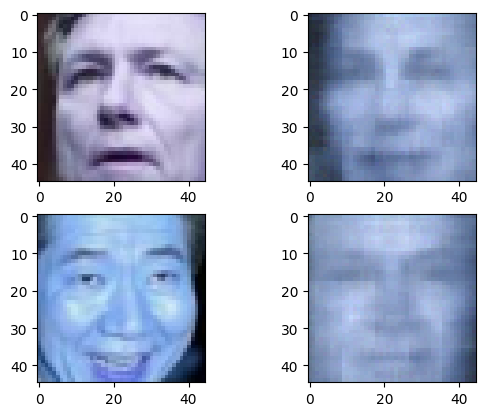

1000/1000 [==============================] - 19s 6ms/step - loss: 140.1162 - reconstruction_loss: 120.6100 - kl_loss: 19.5062 - val_loss: 106.7622 - val_reconstruction_loss: 88.6894 - val_kl_loss: 18.0729
Epoch 2/50
1000/1000 [==============================] - 6s 6ms/step - loss: 104.2961 - reconstruction_loss: 85.1859 - kl_loss: 19.1100 - val_loss: 100.3822 - val_reconstruction_loss: 79.5747 - val_kl_loss: 20.8075
Epoch 3/50
 997/1000 [============================>.] - ETA: 0s - loss: 97.0770 - reconstruction_loss: 76.6287 - kl_loss: 20.4482

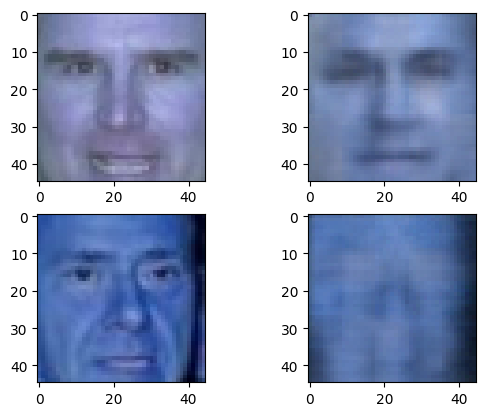

1000/1000 [==============================] - 7s 7ms/step - loss: 97.0212 - reconstruction_loss: 76.5753 - kl_loss: 20.4458 - val_loss: 91.4586 - val_reconstruction_loss: 70.8327 - val_kl_loss: 20.6260
Epoch 4/50
1000/1000 [==============================] - 6s 6ms/step - loss: 88.5175 - reconstruction_loss: 68.6690 - kl_loss: 19.8485 - val_loss: 83.7050 - val_reconstruction_loss: 63.1572 - val_kl_loss: 20.5478
Epoch 5/50
 990/1000 [============================>.] - ETA: 0s - loss: 82.2268 - reconstruction_loss: 63.0809 - kl_loss: 19.1459

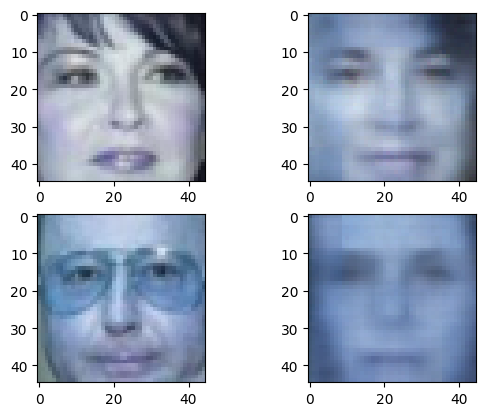

1000/1000 [==============================] - 6s 6ms/step - loss: 82.1811 - reconstruction_loss: 63.0332 - kl_loss: 19.1479 - val_loss: 80.2580 - val_reconstruction_loss: 62.3177 - val_kl_loss: 17.9403
Epoch 6/50
1000/1000 [==============================] - 5s 5ms/step - loss: 78.7075 - reconstruction_loss: 59.9385 - kl_loss: 18.7691 - val_loss: 77.0689 - val_reconstruction_loss: 57.7671 - val_kl_loss: 19.3019
Epoch 7/50
 996/1000 [============================>.] - ETA: 0s - loss: 76.8527 - reconstruction_loss: 58.0994 - kl_loss: 18.7534

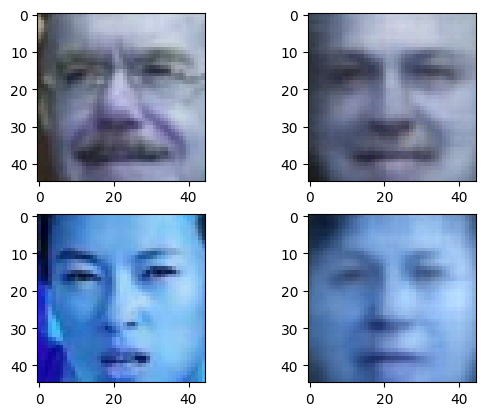

1000/1000 [==============================] - 7s 7ms/step - loss: 76.8283 - reconstruction_loss: 58.0810 - kl_loss: 18.7473 - val_loss: 76.3165 - val_reconstruction_loss: 57.1191 - val_kl_loss: 19.1974
Epoch 8/50
1000/1000 [==============================] - 5s 5ms/step - loss: 75.6471 - reconstruction_loss: 56.9365 - kl_loss: 18.7106 - val_loss: 74.5870 - val_reconstruction_loss: 55.6946 - val_kl_loss: 18.8924
Epoch 9/50
 998/1000 [============================>.] - ETA: 0s - loss: 74.5425 - reconstruction_loss: 55.7532 - kl_loss: 18.7893

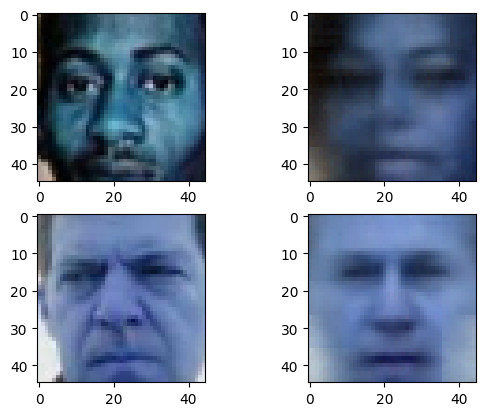

1000/1000 [==============================] - 7s 7ms/step - loss: 74.5488 - reconstruction_loss: 55.7623 - kl_loss: 18.7864 - val_loss: 73.2831 - val_reconstruction_loss: 55.2467 - val_kl_loss: 18.0364
Epoch 10/50
1000/1000 [==============================] - 6s 6ms/step - loss: 73.9176 - reconstruction_loss: 55.0929 - kl_loss: 18.8247 - val_loss: 74.0275 - val_reconstruction_loss: 54.9981 - val_kl_loss: 19.0295
Epoch 11/50
 995/1000 [============================>.] - ETA: 0s - loss: 73.0645 - reconstruction_loss: 54.2833 - kl_loss: 18.7812

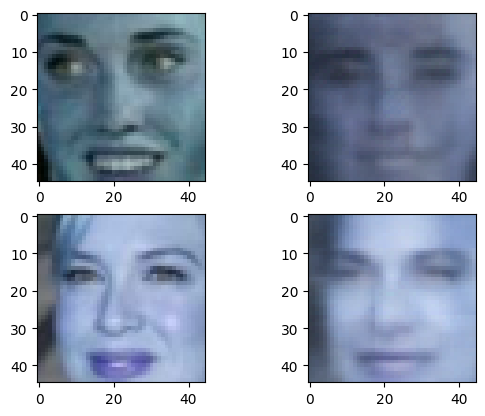

1000/1000 [==============================] - 7s 7ms/step - loss: 73.0787 - reconstruction_loss: 54.2960 - kl_loss: 18.7827 - val_loss: 71.7411 - val_reconstruction_loss: 52.5223 - val_kl_loss: 19.2189
Epoch 12/50
1000/1000 [==============================] - 5s 5ms/step - loss: 72.4814 - reconstruction_loss: 53.6175 - kl_loss: 18.8638 - val_loss: 71.7593 - val_reconstruction_loss: 52.5758 - val_kl_loss: 19.1834
Epoch 13/50
 996/1000 [============================>.] - ETA: 0s - loss: 72.1955 - reconstruction_loss: 53.3413 - kl_loss: 18.8542

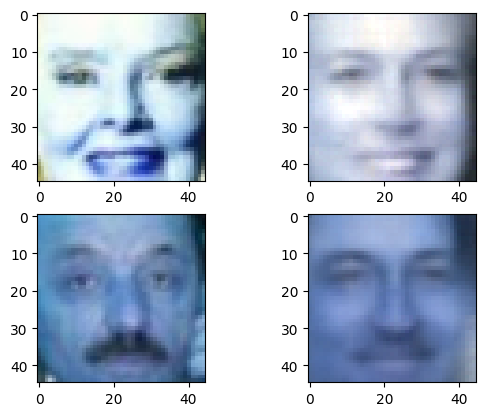

1000/1000 [==============================] - 7s 7ms/step - loss: 72.2074 - reconstruction_loss: 53.3488 - kl_loss: 18.8587 - val_loss: 72.7059 - val_reconstruction_loss: 53.7782 - val_kl_loss: 18.9278
Epoch 14/50
1000/1000 [==============================] - 6s 6ms/step - loss: 71.9825 - reconstruction_loss: 53.1204 - kl_loss: 18.8621 - val_loss: 71.3249 - val_reconstruction_loss: 52.1149 - val_kl_loss: 19.2100
Epoch 15/50
 997/1000 [============================>.] - ETA: 0s - loss: 71.6485 - reconstruction_loss: 52.7660 - kl_loss: 18.8824

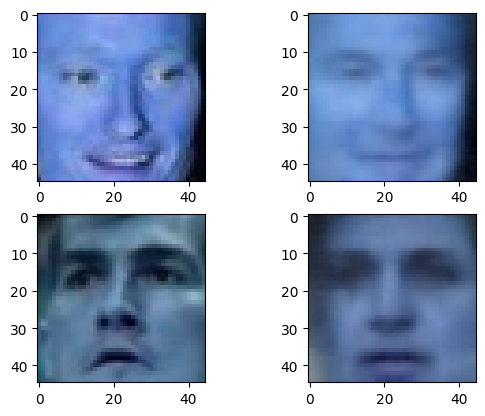

1000/1000 [==============================] - 6s 6ms/step - loss: 71.6354 - reconstruction_loss: 52.7503 - kl_loss: 18.8852 - val_loss: 70.8580 - val_reconstruction_loss: 50.6590 - val_kl_loss: 20.1990
Epoch 16/50
1000/1000 [==============================] - 6s 6ms/step - loss: 71.2656 - reconstruction_loss: 52.3940 - kl_loss: 18.8716 - val_loss: 71.5306 - val_reconstruction_loss: 53.1085 - val_kl_loss: 18.4221
Epoch 17/50
 995/1000 [============================>.] - ETA: 0s - loss: 71.2728 - reconstruction_loss: 52.3547 - kl_loss: 18.9180

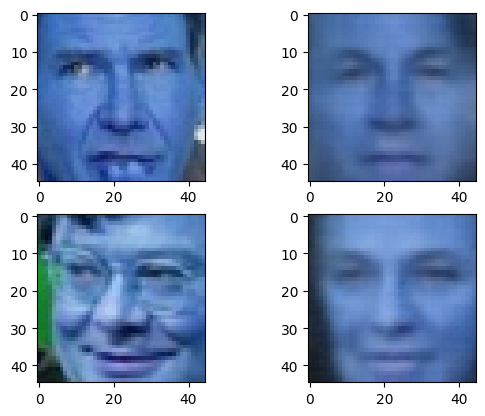

1000/1000 [==============================] - 6s 6ms/step - loss: 71.2831 - reconstruction_loss: 52.3640 - kl_loss: 18.9190 - val_loss: 71.0300 - val_reconstruction_loss: 53.5413 - val_kl_loss: 17.4886
Epoch 18/50
1000/1000 [==============================] - 7s 7ms/step - loss: 70.7953 - reconstruction_loss: 51.8852 - kl_loss: 18.9100 - val_loss: 70.8456 - val_reconstruction_loss: 51.2941 - val_kl_loss: 19.5515
Epoch 19/50
 996/1000 [============================>.] - ETA: 0s - loss: 70.5012 - reconstruction_loss: 51.6201 - kl_loss: 18.8811

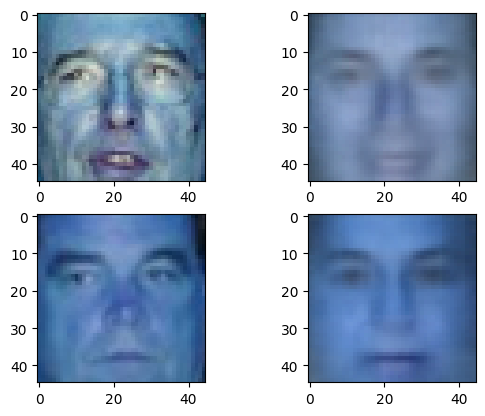

1000/1000 [==============================] - 6s 6ms/step - loss: 70.5311 - reconstruction_loss: 51.6452 - kl_loss: 18.8858 - val_loss: 70.7135 - val_reconstruction_loss: 51.7951 - val_kl_loss: 18.9184
Epoch 20/50
1000/1000 [==============================] - 6s 6ms/step - loss: 70.3997 - reconstruction_loss: 51.4934 - kl_loss: 18.9063 - val_loss: 70.8163 - val_reconstruction_loss: 52.7153 - val_kl_loss: 18.1010
Epoch 21/50
 996/1000 [============================>.] - ETA: 0s - loss: 70.3038 - reconstruction_loss: 51.3011 - kl_loss: 19.0026

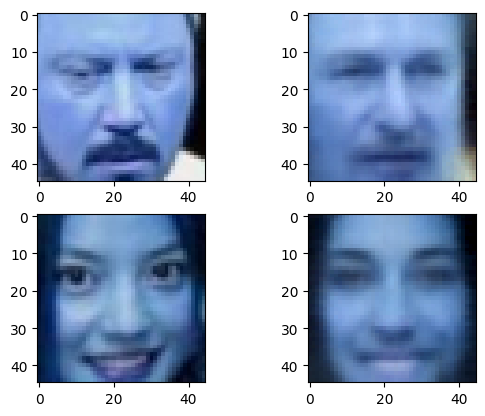

1000/1000 [==============================] - 6s 6ms/step - loss: 70.3099 - reconstruction_loss: 51.3051 - kl_loss: 19.0048 - val_loss: 69.8867 - val_reconstruction_loss: 51.4070 - val_kl_loss: 18.4797
Epoch 22/50
1000/1000 [==============================] - 7s 7ms/step - loss: 70.0522 - reconstruction_loss: 51.1596 - kl_loss: 18.8925 - val_loss: 69.6695 - val_reconstruction_loss: 50.5900 - val_kl_loss: 19.0794
Epoch 23/50
 995/1000 [============================>.] - ETA: 0s - loss: 69.8935 - reconstruction_loss: 50.9220 - kl_loss: 18.9715

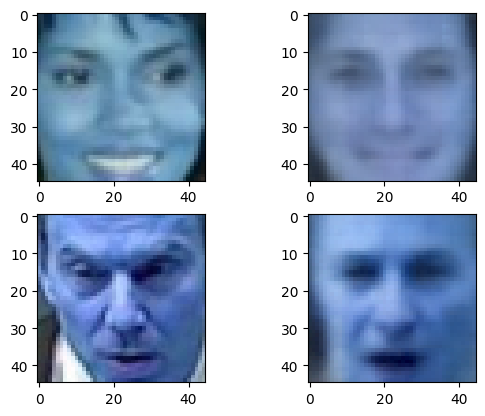

1000/1000 [==============================] - 7s 7ms/step - loss: 69.8821 - reconstruction_loss: 50.9115 - kl_loss: 18.9706 - val_loss: 68.9578 - val_reconstruction_loss: 50.6742 - val_kl_loss: 18.2837
Epoch 24/50
1000/1000 [==============================] - 7s 7ms/step - loss: 69.7998 - reconstruction_loss: 50.8353 - kl_loss: 18.9645 - val_loss: 69.1071 - val_reconstruction_loss: 50.0616 - val_kl_loss: 19.0455
Epoch 25/50
 995/1000 [============================>.] - ETA: 0s - loss: 69.6870 - reconstruction_loss: 50.7201 - kl_loss: 18.9668

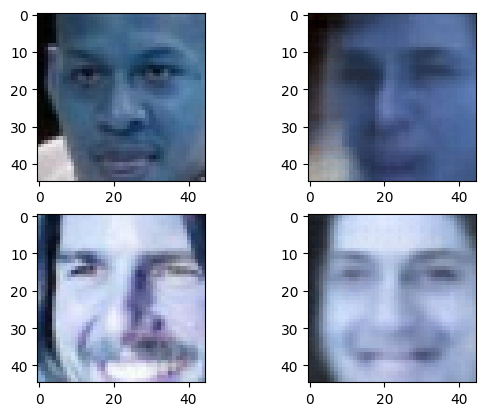

1000/1000 [==============================] - 7s 7ms/step - loss: 69.7125 - reconstruction_loss: 50.7370 - kl_loss: 18.9754 - val_loss: 69.2125 - val_reconstruction_loss: 50.1342 - val_kl_loss: 19.0783
Epoch 26/50
1000/1000 [==============================] - 6s 6ms/step - loss: 69.5194 - reconstruction_loss: 50.5924 - kl_loss: 18.9269 - val_loss: 69.5449 - val_reconstruction_loss: 50.7026 - val_kl_loss: 18.8423
Epoch 27/50
 992/1000 [============================>.] - ETA: 0s - loss: 69.4317 - reconstruction_loss: 50.4542 - kl_loss: 18.9776

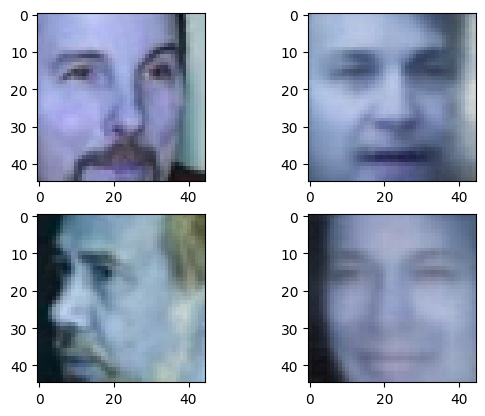

1000/1000 [==============================] - 6s 6ms/step - loss: 69.4228 - reconstruction_loss: 50.4405 - kl_loss: 18.9823 - val_loss: 69.1430 - val_reconstruction_loss: 50.1668 - val_kl_loss: 18.9762
Epoch 28/50
1000/1000 [==============================] - 6s 6ms/step - loss: 69.4236 - reconstruction_loss: 50.4651 - kl_loss: 18.9584 - val_loss: 69.5182 - val_reconstruction_loss: 50.4717 - val_kl_loss: 19.0465


In [ ]:
history = vae.fit(
    X_train,
    validation_data=(X_val, X_val),
    epochs=epochs,
    batch_size=10,
    callbacks=[callback, early_stop]
)

Some visualization things :)

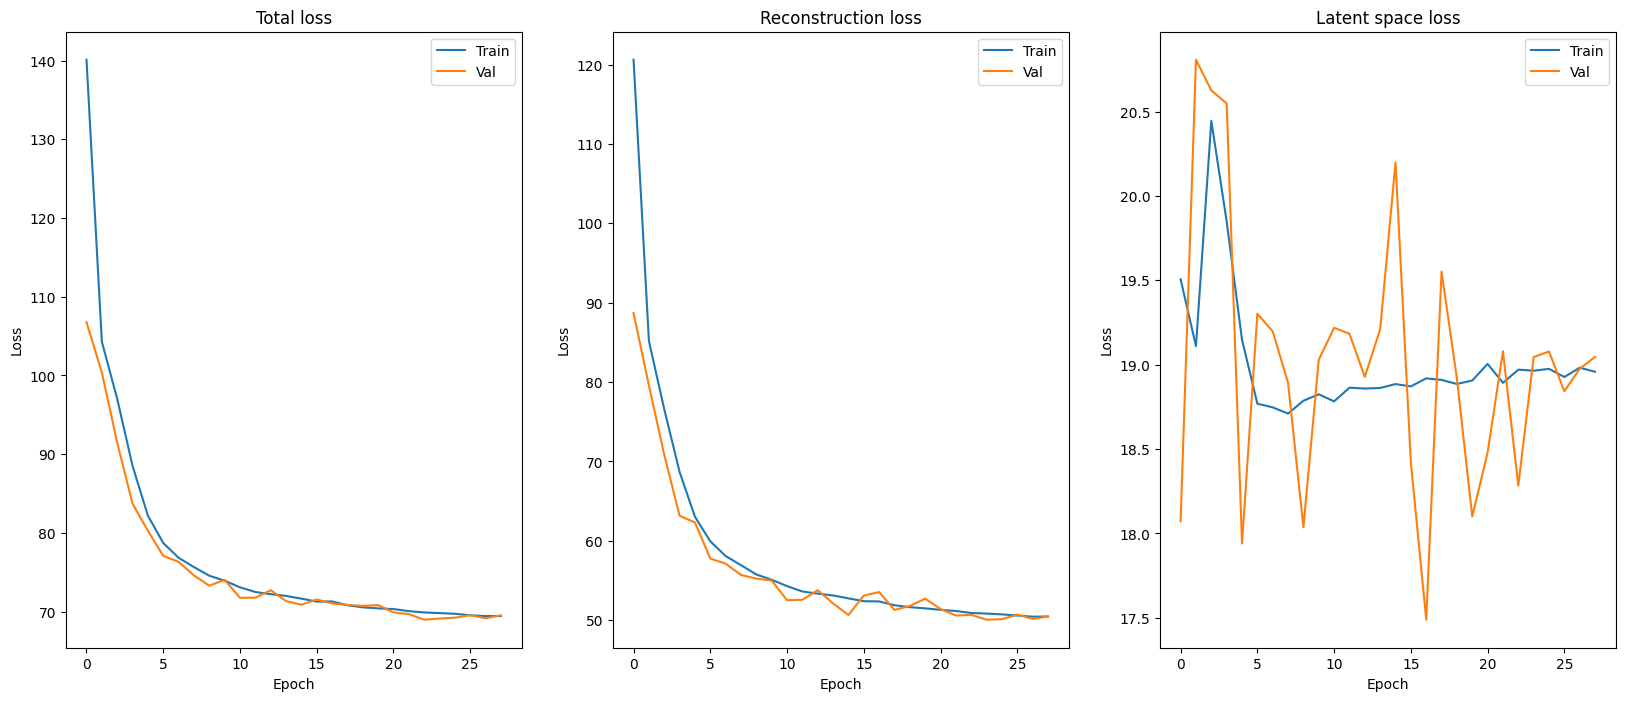

In [ ]:
plt.figure(figsize=(20, 8))
plt.subplot(131)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Total loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'])

plt.subplot(132)
plt.plot(history.history['reconstruction_loss'])
plt.plot(history.history['val_reconstruction_loss'])
plt.title('Reconstruction loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'])

plt.subplot(133)
plt.plot(history.history['kl_loss'])
plt.plot(history.history['val_kl_loss'])
plt.title('Latent space loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'])
plt.show()

Sampling some latent vector from N(0, 1) and passing it through the decoder

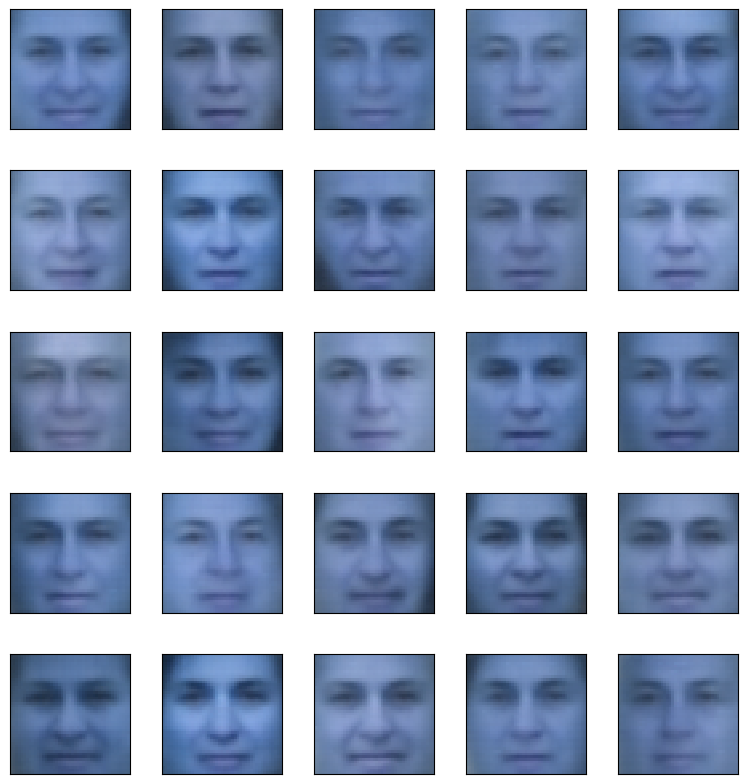

In [ ]:
z = np.random.randn(25, 450) * 0.5
output = vae.decoder(z).numpy()
plot_gallery(output, image_h, image_w, n_row=5, n_col=5)

The bonus part - smiling/non smiling etc. :)

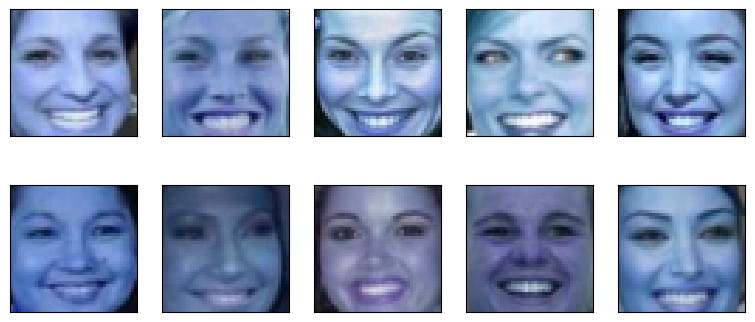

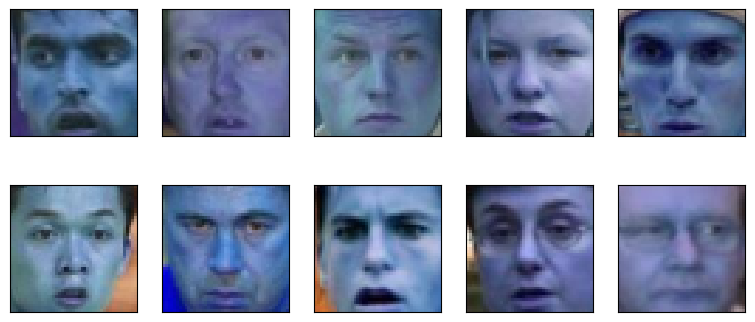

In [ ]:
# smiling/non-smiling faces extraction
sorted_smiling = attrs.Smiling.argsort().values
idx_smiling = sorted_smiling[-10:][::-1]
idx_non_smiling = sorted_smiling[:10]
# scaling
X_smiling = data[idx_smiling] / 255.0
X_non_smiling = data[idx_non_smiling] / 255.0

plot_gallery(X_smiling, image_h, image_w, n_row=2, n_col=5)
plot_gallery(X_non_smiling, image_h, image_w, n_row=2, n_col=5)

In [ ]:
# Extract the mean, log_var and latent of smiling pictures
# Calculate the mean values of extracted "features"
smile_mean, smile_log_var, smile = vae.encoder(X_smiling)
smile_mean = smile_mean.numpy().mean(axis=0)
smile_log_var = smile_log_var.numpy().mean(axis=0)
smile = smile.numpy().mean(axis=0)
# Same thing for the not-smiling images
non_smile_mean, non_smile_log_var, non_smile = vae.encoder(X_non_smiling)
non_smile_mean = non_smile_mean.numpy().mean(axis=0)
non_smile_log_var = non_smile_log_var.numpy().mean(axis=0)
non_smile = non_smile.numpy().mean(axis=0)
# Differences
diff_mean = smile_mean - non_smile_mean
diff_log_var = smile_log_var - non_smile_log_var
diff = smile - non_smile

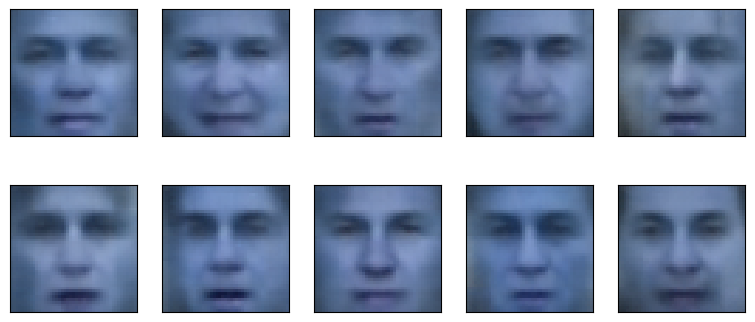

In [ ]:
# Sample a z and pass it as an epsilon
# Pass the non-smile "tricked" vector to the trained decoder
z = np.random.randn(10, 450)
output = vae.decoder(non_smile_mean + np.exp(0.5 * non_smile_log_var) * z).numpy()
plot_gallery(output, image_h, image_w, n_row=2, n_col=5)

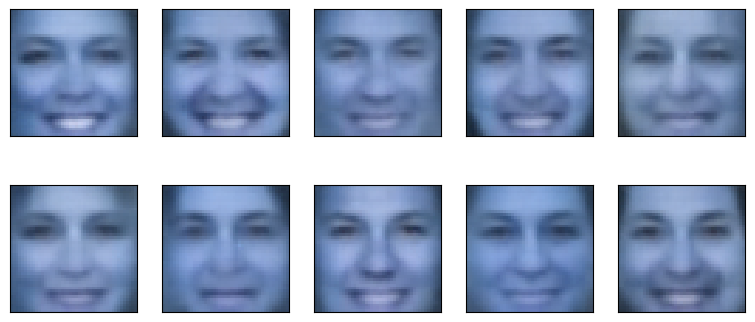

In [ ]:
# Pass the smiling "tricked" vector to the trained decoder
smiling_output = vae.decoder(smile_mean + np.exp(0.5 * smile_log_var) * z).numpy()
plot_gallery(smiling_output, image_h, image_w, n_row=2, n_col=5)